# <p style="text-align: center;">Electric Vehicles Based on Washington State Population</p>

   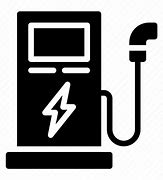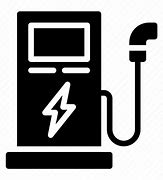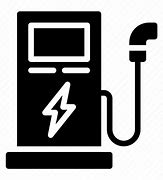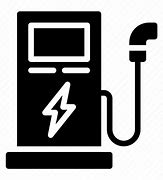   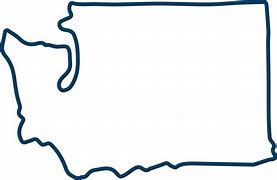

In [113]:

# Dependencies and Setup
import uszipcode
from uszipcode import SearchEngine
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import requests
import json
from census import Census
from us import states

api_key = '10da8c6fe34292f1c2578a5f43cddc1fe8a98a25'


# Census API

In [98]:

c = Census(
    api_key,
    year = 2020
)
census_data_counties = c.acs5.get(
    ("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E"),
    {'for': 'county:*', 'in': 'state:53'}
)

# Convert the county data to a DataFrame
county_pd = pd.DataFrame(census_data_counties)

# Column renaming
county_pd = county_pd.rename(
    columns={
        "B01003_001E": "Population",
        "B19013_001E": "Household Income",
        "NAME": "County",
        "state": "State Code",
        "county": "County Code"
    }
)
# Remove " County, Washington" from the county names
county_pd["County"] = county_pd["County"].str.replace(" County, Washington", "")
# Add a Poverty Rate column (Poverty Count / Population)


# Configure the final DataFrame
county_pd = county_pd[
    [
        "County",
        "Population",        
        "Household Income",     
              
    ]
]



# Electric Data Population.csv Set:

In [99]:
wa_data="C://Users//kayvb//OneDrive//Desktop//Electric_Vehicle_Population_Data.csv"
wa_df = pd.read_csv(wa_data)

wa_df.columns


Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

# Dropped unwanted columns and rows

In [100]:
wa_df.drop(['VIN (1-10)','Postal Code','Base MSRP','Legislative District','DOL Vehicle ID','Vehicle Location','2020 Census Tract'], axis=1, inplace=True)

wa_df = wa_df[wa_df['Electric Range'] !=0]

# Merging both DataFrames

In [101]:
#Setting our Data to only include Washington State
wa_count= wa_df[wa_df['State'] == 'WA']
vehicle_census = pd.merge(county_pd, wa_count)
vehicle_census

,County,Population,Household Income,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility
0,Adams,19702.0,51601.0,Lind,WA,2020,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32,AVISTA CORP
1,Adams,19702.0,51601.0,Ritzville,WA,2014,FORD,C-MAX,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
2,Adams,19702.0,51601.0,Othello,WA,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
3,Adams,19702.0,51601.0,Othello,WA,2016,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
4,Adams,19702.0,51601.0,Ritzville,WA,2020,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,259,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
...,...,...,...,...,...,...,...,...,...,...,...,...
78409,Whitman,49577.0,42288.0,Colfax,WA,2018,TOYOTA,PRIUS PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
78410,Whitman,49577.0,42288.0,Pullman,WA,2023,KIA,SPORTAGE,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,34,AVISTA CORP
78411,Whitman,49577.0,42288.0,Pullman,WA,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266,AVISTA CORP
78412,Whitman,49577.0,42288.0,Pullman,WA,2018,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,100,AVISTA CORP


# Setting a list of Urban Counties in Washington State
- Created a Function to Filter all other Counties to Rural
- Inserting a new column for County Types

In [102]:
urban_counties = ['Clark', 'Thurston', 'Pierce', 'King', 'Kitsap', 'Snohomish', 'Whatcom', 'Spokane', 'Benton']

# Function to determine the type based on the county
def determine_type(county):
    if county in urban_counties:
        return 'Urban'
    else:
        return 'Rural'

# Add the 'Type' column to the DataFrame
vehicle_census.insert(1, 'County Type', vehicle_census['County'].apply(determine_type))




# Cleaned Data Frame

In [103]:
vehicle_census.head()

,County,County Type,Population,Household Income,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility
0,Adams,Rural,19702.0,51601.0,Lind,WA,2020,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32,AVISTA CORP
1,Adams,Rural,19702.0,51601.0,Ritzville,WA,2014,FORD,C-MAX,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
2,Adams,Rural,19702.0,51601.0,Othello,WA,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
3,Adams,Rural,19702.0,51601.0,Othello,WA,2016,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
4,Adams,Rural,19702.0,51601.0,Ritzville,WA,2020,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,259,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...


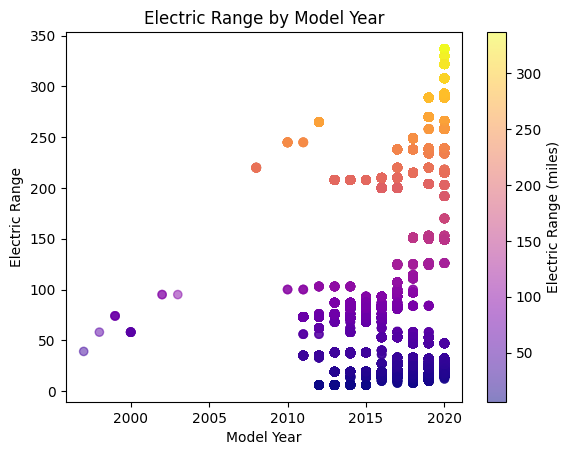

In [105]:
# Filter out rows with missing 'Electric Range' values and limit to 1997-2020 Model Years
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = pd.to_numeric(vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >= 1997) & (vehicle_census_filtered['Model Year'] <= 2020)]

# Set the color for the scatter plot
colors = plt.colormaps.get_cmap('plasma')  # Choose a colormap (e.g., 'coolwarm', 'viridis', 'plasma', etc.)

# Plot the scatter plot
plt.scatter(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'],  c=vehicle_census_filtered['Electric Range'], cmap=colors, alpha=0.5)
plt.colorbar(label='Electric Range (miles)')
# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Electric Range')

# Set the title
plt.title('Electric Range by Model Year')

# Show the plot
plt.show()
# Assuming you have the 'vehicle_census' DataFrame with the necessary data

The correlation between Model Year and Electric Range is: 0.51


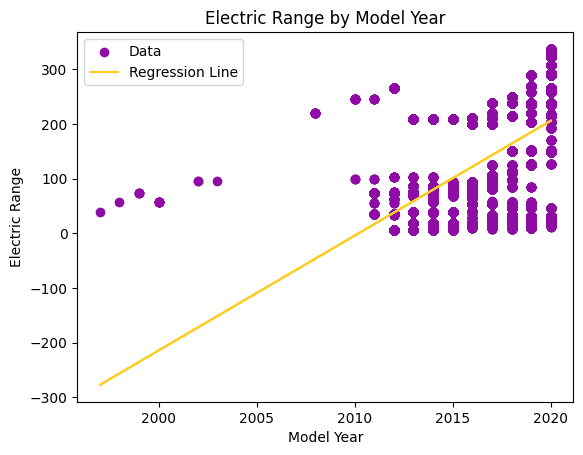

In [106]:
# Filter out rows with missing 'Electric Range' values and limit to 1997-2020 Model Years
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = pd.to_numeric(vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >= 1997) & (vehicle_census_filtered['Model Year'] <= 2020)]

# Check if 'Model Year' column has varying values
if len(vehicle_census_filtered['Model Year'].unique()) == 1:
    print("Error: 'Model Year' column has constant values. Cannot perform linear regression.")
else:
    # Calculate the correlation coefficient
    correlation_coef, _ = st.pearsonr(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'])
    print("The correlation between Model Year and Electric Range is: {:.2f}".format(correlation_coef))

    # Perform linear regression
    slope, intercept, rvalue, pvalue, _ = st.linregress(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'])

    # Create the regression line data
    regression_line = slope * vehicle_census_filtered['Model Year'] + intercept

    # Set the color for the scatter plot and regression line
    cmap = plt.get_cmap('plasma')  # Choose a colormap (e.g., 'coolwarm', 'viridis', 'plasma', etc.)

    # Plot the scatter plot with regression line
    plt.scatter(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'], color=cmap(0.3), label='Data')
    plt.plot(vehicle_census_filtered['Model Year'], regression_line, color=cmap(0.9), label='Regression Line')

    # Set the x-axis and y-axis labels
    plt.xlabel('Model Year')
    plt.ylabel('Electric Range')

    # Set the title
    plt.title('Electric Range by Model Year')

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

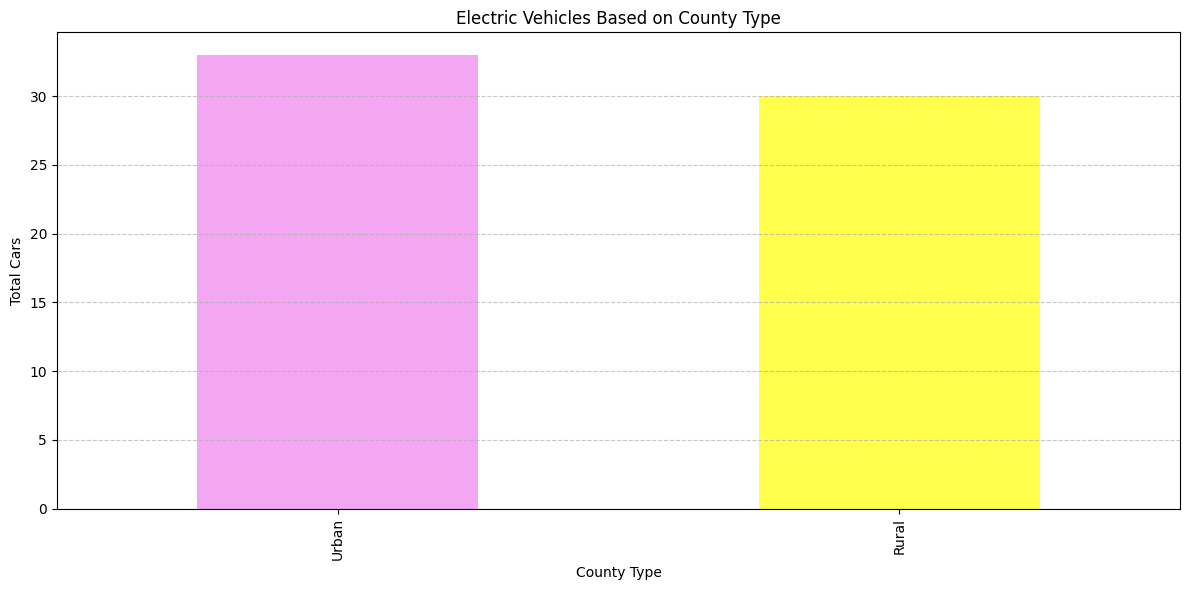

In [107]:
# Group the data by county and calculate the total number of cars in each county
total_cars_by_county = vehicle_census.groupby('County Type')['Make'].nunique()

# Calculate the correlation between the total cars and electric range for each county
total_cars_by_county = total_cars_by_county.sort_values(ascending=False)
colors=['violet','yellow']
# Plot the bar graph
plt.figure(figsize=(12, 6))
total_cars_by_county.plot(kind='bar', color=colors, alpha=0.7)
plt.xlabel('County Type')
plt.ylabel('Total Cars')
plt.title('Electric Vehicles Based on County Type')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()